<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

In [18]:
!nvidia-smi

Sat May 15 16:28:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |  15729MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Select the path for current run images, pay attention, old images in the path will be overwritten!

In [2]:
# for logging train images
if False:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    runpath = "/content/drive/MyDrive/progetto_asperti/run2"
    os.makedirs(runpath)


In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import os
import gdown
from zipfile import ZipFile #chose this or !unzip

from tqdm.notebook import tqdm

## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [3]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Already downloaded")

Download face attributes hosted on public 
github

In [5]:
USE_LABELS = False
if USE_LABELS:
    !wget -q -O "/content/celeba_gan/list_attr_celeba.txt.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba.txt.zip?raw=true" 
    !unzip "/content/celeba_gan/list_attr_celeba.txt.zip" -d "/content/celeba_gan"

# Keras Dataset 
create Dataset object from our folder, and rescale the images to the [0-1] range:

In [4]:

dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=128
)
dataset = dataset.map(lambda x: x / 255.0)
dataset.element_spec

Found 202599 files belonging to 1 classes.


TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)

Let's display a sample image:

dataset length: 1583


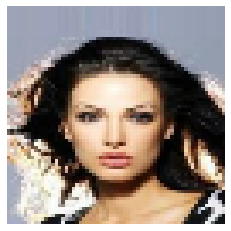

In [5]:
print(f"dataset length: {len(dataset)}")
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


# Model

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [6]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [7]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

## Override `train_step`

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create callbacks

In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=8, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        if ENABLE_WANDB:
            log_images = [wandb.Image(img) for img in generated_images]
            wandb.log({f"Epoch {epoch}": (log_images)})

        """else:
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(f"{self.path}/generated_img_{epoch:03d}_{i}.png")"""

## Ceckpoint local logger

In [10]:
SAVE_PATH = './models/'
os.makedirs(SAVE_PATH, exist_ok=True)

In [11]:
class WeightsLogger(keras.callbacks.Callback):
    def __init__(self, save_path=SAVE_PATH):
        self.save_path = save_path
        print("WeightsLogger init")

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(self.save_path+f'generator_checkpoint_{epoch}.h5')
        self.model.discriminator.save(self.save_path+f'discriminator_checkpoint_{epoch}.h5')


## Train the end-to-end model

### Train

In [12]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [13]:

ENABLE_WANDB = True        #@param {type:"boolean"}
wandb_experiment_name = "logger_run" #@param {type: "string"}
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project="GAN", name=wandb_experiment_name, resume=True)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


In [15]:
# NEW RUN
run = wandb.init(project="GAN", name=wandb_experiment_name)

In [14]:
# RESUME RUN
run = wandb.init(project='GAN', resume=True)

In [16]:
epochs = 100  # In practice, use ~100 epochs

gan.fit(dataset, epochs=epochs,# initial_epoch=7,
        callbacks=[
            WandbCallback(log_batch_frequency=10),
            GANMonitor(num_img=8, latent_dim=latent_dim),
            WeightsLogger()]
            #FIDLogger()]
)

WeightsLogger init
Epoch 1/100
1583/1583 [==============================] - 596s 364ms/step - d_loss: 0.5416 - g_loss: 1.5603
Epoch 2/100
1583/1583 [==============================] - 587s 370ms/step - d_loss: 0.6014 - g_loss: 1.2994
Epoch 3/100
1583/1583 [==============================] - 577s 364ms/step - d_loss: 0.6217 - g_loss: 1.2760
Epoch 4/100
1583/1583 [==============================] - 571s 360ms/step - d_loss: 0.6409 - g_loss: 1.2904
Epoch 5/100
1583/1583 [==============================] - 570s 360ms/step - d_loss: 0.6285 - g_loss: 1.1810
Epoch 6/100
1583/1583 [==============================] - 579s 366ms/step - d_loss: 0.6433 - g_loss: 1.2619
Epoch 7/100
1583/1583 [==============================] - 581s 367ms/step - d_loss: 0.6362 - g_loss: 1.0637
Epoch 8/100
1583/1583 [==============================] - 572s 361ms/step - d_loss: 0.6564 - g_loss: 1.1488
Epoch 9/100
1583/1583 [==============================] - 577s 364ms/step - d_loss: 0.6521 - g_loss: 1.1268
Epoch 10/100
1583/

In [17]:
# log checkpoint artifacts to wandb
run = wandb.init(project='GAN', resume=True)

artifact = wandb.Artifact('gan_models', type='model')

artifact.add_dir('models')

run.log_artifact(artifact)
run.join()

d_loss,0.64421
g_loss,1.03127
_runtime,55774
_timestamp,1621091888
_step,16099
epoch,99


d_loss,▁▇▇▇▆▇▇▆▇▆▇▇███▇▇████▇█▇▇██▇▇▇▇▇▆▇▆▇▆▆▆▆
g_loss,█▄▄▄▄▄▃▂▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Adding directory to artifact (./models)... Done. 28.2s


In [100]:
# load model

artifact = run.use_artifact('buio/GAN/gan_models:v1', type='model')
artifact_dir = artifact.download()

run.join()

print('\n', artifact_dir)
models = os.listdir(artifact_dir)
generators = [model for model in models if 'generator' in model]
discriminators = [model for model in models if 'discriminator' in model]

def run_num(run_name):
    return int(run_name.strip('h5').strip('.').split('_')[-1])

generators.sort(key=run_num)
discriminators.sort(key=run_num)
print(*generators,sep='\n')

wandb: Downloading large artifact gan_models:v1, 335.43MB. 40 files... Done. 0:0:0



 ./artifacts/gan_models:v1
generator_checkpoint_0.h5
generator_checkpoint_1.h5
generator_checkpoint_2.h5
generator_checkpoint_3.h5
generator_checkpoint_4.h5
generator_checkpoint_5.h5
generator_checkpoint_6.h5
generator_checkpoint_7.h5
generator_checkpoint_8.h5
generator_checkpoint_9.h5
generator_checkpoint_10.h5
generator_checkpoint_11.h5
generator_checkpoint_12.h5
generator_checkpoint_13.h5
generator_checkpoint_14.h5
generator_checkpoint_15.h5
generator_checkpoint_16.h5
generator_checkpoint_17.h5
generator_checkpoint_18.h5
generator_checkpoint_19.h5


In [103]:
# ri-populate model
generator = tf.keras.models.load_model(artifact_dir+'/'+generators[-1])
discriminator = tf.keras.models.load_model(artifact_dir+'/'+discriminators[-1])

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.fit(dataset, epochs=1, steps_per_epoch=2)


2/2 [==============================] - 3s 556ms/step - d_loss: 0.7721 - g_loss: 0.8777


# FID score 


## Real Images

In [11]:
BATCH_SIZE = 128

# loading real images in 64x64 and upsampling as for the generated ones
fid_real_loader = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size = BATCH_SIZE,
    interpolation='bilinear', shuffle=True
)

def resize_and_preprocess(image):

    # resize the image to the expected input size for inception model
    image = tf.image.resize(image, (229,229), method='nearest')

    # preprocess image requied by inception model
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)

    return image
    
fid_real_loader = (
    fid_real_loader
    .map(resize_and_preprocess)
)

FID_COUNT = 100

inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

def compute_embeddings(dataloader, count):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)[:FID_COUNT]

count = int(np.ceil(FID_COUNT/BATCH_SIZE))

print(count)
# compute embeddings for real images
real_image_embeddings = compute_embeddings(fid_real_loader, count)


Found 202599 files belonging to 1 classes.


TensorSpec(shape=(None, 229, 229, 3), dtype=tf.float32, name=None)

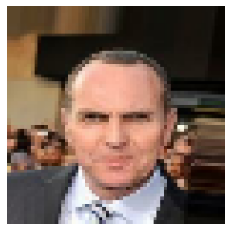

In [12]:
for x in fid_real_loader:
    plt.axis("off")
    plt.imshow(((x.numpy()*0.5+0.5) * 255).astype("int32")[0])
    break

In [13]:
FID_COUNT = 100

inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

def compute_embeddings(dataloader, count):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)[:FID_COUNT]

count = int(np.ceil(FID_COUNT/BATCH_SIZE))

print(count)
# compute embeddings for real images
real_image_embeddings = compute_embeddings(fid_real_loader, count)
real_image_embeddings.shape

87916544/87910968 [==============================] - 1s 0us/step
1


(100, 2048)

## Generated Images

In [38]:
NOISE_DIM = 128
BATCH_SIZE = 128

def generate_images(l, model):
    # generate images using the trained generator
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    images = model(noise)

    # prepare the images for resize_and_preprocess function
    images = tf.image.convert_image_dtype(images, dtype=tf.uint8)

    return images

fid_gen_loader = tf.data.Dataset.from_tensors([1])

fid_gen_loader = (
    fid_gen_loader
    .map(lambda x: generate_images(x, gan.generator))
    .map(resize_and_preprocess)
    .prefetch(BATCH_SIZE)
)

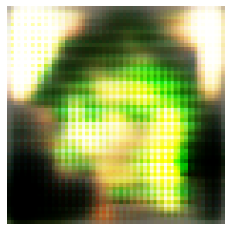

In [29]:
for x in fid_gen_loader:
    plt.axis("off")
    plt.imshow(((x.numpy()*0.5+0.5) * 255).astype("int32")[0])
    break

In [78]:
count = int(np.ceil(1000/BATCH_SIZE))

# compute embeddings for fake images

%time gen_image_embeddings = compute_embeddings(fid_gen_loader, count)

gen_image_embeddings.shape

KeyboardInterrupt: ignored

In [65]:
import time

def timeit(func):
    def wrapper(*args, **kargs):
        start = time.time()
        ret = func(*args, **kargs)
        lap = time.time() - start
        print(f'{func.__name__} took {lap:.3} seconds')
        return ret
    return wrapper



f took 9.54e-07 seconds
100


Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)